In [2]:
from geojson import Feature, Point, FeatureCollection
from shapely.geometry import Polygon, LineString, MultiLineString, MultiPolygon
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import geopandas as gpd
from osgeo import gdal
import pandas as pd
import numpy as np
%matplotlib inline
import subprocess
import shapely
import geojson
import folium
import pyproj

In [4]:
data = "data.geojson"
geodata = geojson.load(open(data))
# type(geodata)

In [3]:
def create_gdf(geodata):
    ''' 
    THis function is used to loop through the geojson file and create a dataframe of each object in the geojson
    '''
    
    tmp = []
    polygons = []
    line=[]
    for i in range(0, len(geodata['features'])):
        if i!=9:
            for j in range(0, len(geodata['features'][i]['geometry']["coordinates"])):

                if len(geodata['features'][i]['geometry']["coordinates"][j]) >= 3:
                    polygons.append(Polygon(geodata['features'][i]['geometry']["coordinates"][j]))

            # ading the dictionary to the list to be used to create the data frame
            tmp.append( {
                    'Slabel': geodata['features'][i]['properties']['Slabel'],
                    'Plabel': geodata['features'][i]['properties']['Plabel'],
                    'geometry' : MultiPolygon(polygons)
               })
            
        # looping through class nine and creating multiline string   
        else:
            for k in range(0, len(geodata['features'][i]['geometry']["coordinates"])):
                if len(geodata['features'][i]['geometry']["coordinates"][k]) >=2:
                    line.append(LineString(geodata['features'][i]['geometry']["coordinates"][k]))
            tmp.append({
                'Slabel': geodata['features'][i]['properties']['Slabel'],
                'Plabel': geodata['features'][i]['properties']['Plabel'],
                'geometry' :  MultiLineString(line)
                })
            
        # emptying the polygon list after creating the first Multipolygon
        del polygons[:]

    # creating the geodataframe from the list of dictionaries
    gdf = gpd.GeoDataFrame(tmp)

    # setting the index to start from 1
#     gdf.index = np.arange(1, len(gdf) + 1)
    
    # setting the crs(projected) to  the geodataframe
    gdf = gdf.set_crs('epsg:32631') 
    
    # fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    # gdf.plot(ax=ax, color='yellow', edgecolor='green', cmap='OrRd')
    
    return gdf
    
# create_gdf()

In [4]:
def process_data(thin_cld, thick_cld):
    '''a function to remove the overlays between the thick cloud and the thin cloud
    '''
    
    difference=gpd.overlay(thin_cld,thick_cld, how='difference')
#     diff=gpd.overlay(thick_cld, thin_cld, how='difference')

    '''
    # checking the intersection
    intersection=gpd.overlay(thin_cld,thick_cld, how='intersection')
       
    # checking the union
    union=gpd.overlay(intersection,thick_cld, how='union')

    # disolving the union of the two polygons
    union['common_column'] = 1
    dissolved = union.dissolve(by='common_column')

    #ploting
    fig, ax = plt.subplots(1, 1, figsize=(15, 55))
    difference.plot(ax=ax, color='green', edgecolor='red', alpha=1)
    return dissolved.plot(ax=ax, color='lightgrey', edgecolor='blue', alpha=1)
    
    '''
    
    return difference

In [5]:
def new_dataframe(gdf, thick_cld, difference):
    ''' the function is used to create the final dataframe with the cleaned data
    '''
    
    # creating a new datafrme of thick cloud and the cleaned thin cloud
    new_cloud = difference.append(thick_cld)

    # droping rows that have overlays
    gdf_copy = gdf.drop([13,14,15,16,17])

    # adding the new cleaned cloud to the origibal data frame
    new_gdf = gdf_copy.append(new_cloud)

    

    return new_gdf

# fig, ax = plt.subplots(1, 1, figsize=(15, 55))
# difference.plot(ax=ax, color='green', edgecolor='red', alpha=1)
# return dissolved.plot(ax=ax, color='lightgrey', edgecolor='blue', alpha=1)

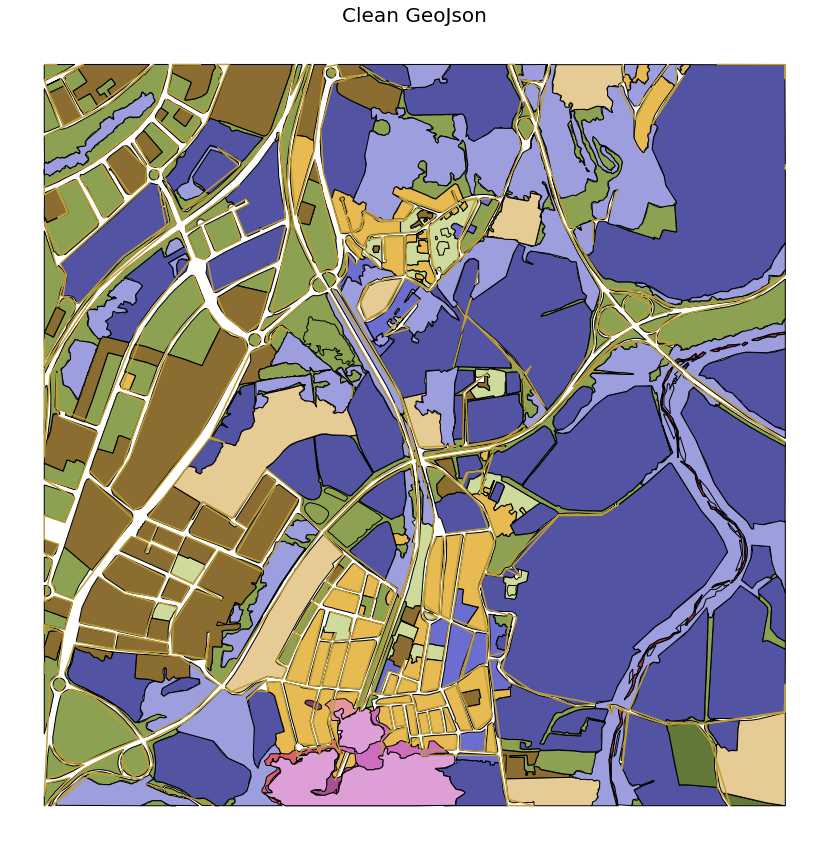

In [6]:
def main(data):
    ''' the function is used to call the main functions and display the final result on a canvas
    '''
    #creating the initial dataframe
    gdf = create_gdf(data)
    
    # ploting the original data frame
    ''' 
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 15))
    gdf.plot(ax= ax1, column='Slabel',edgecolor='k', alpha=1)
    ax1.set_title("Original GeoJson", fontsize=20)
    ax1.set_axis_off()
    '''
    
    # Accessing the Thin and Thick clouds
    thick_cld =  gdf.loc[(gdf["Slabel"] == 82)]
    thin_cld =  gdf.loc[(gdf["Slabel"] == 81)]
    
    
    # getting the difference the thick cloud creates in the thin cloud
    difference = process_data(thin_cld, thick_cld)
    
    # creating the new cleaned dataframe
    new_gdf = new_dataframe(gdf, thick_cld, difference)
    
    
    # writing the new dataframe to geojson file into the file system
    new_gdf.to_file("Delivery.geojson", driver='GeoJSON')
    
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    new_gdf.plot(ax=ax, color='yellow', edgecolor='k', cmap='tab20b', alpha=1)
    ax.set_title("Clean GeoJson", fontsize=20)
    ax.set_axis_off()
    
main(geodata)


In [14]:
data = "data.geojson"
geodata = geojson.load(open(data))

In [15]:
srcDS = gdal.OpenEx(data)
# ds = gdal.VectorTranslate('test.shp', srcDS, format='ESRI Shapefile')

In [16]:
with open('C:/Users/DELL/Desktop/jupyter/data.geojson', 'w') as f:
# with open(data, 'w') as f:
    geojson.dump(geodata, f)

# args = ['ogr2ogr', '-f', 'ESRI Shapefile', 'C:/Users/DELL/Desktop/jupyter/test.shp','data.geojson']
args = ['ogr2ogr', '-f', 'ESRI Shapefile', 'C:/Users/DELL/Desktop/jupyter/test2.shp', data]
# subprocess.Popen(args)